# Extract-Transform-Load Notebook

## Extraction & Exploration
Dataset is available on kaggle. This notebook assumes it's stored in a directory `../datasets/diabetes.csv`.
***

### Setup Environment

In [1]:
# libraries
# !pip install -r ../requirements.txt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# homegrown utilities
from utils.explore_dataset import *
from utils.transform_dataset import *
from utils.dataset import *
from utils.feature_selection import *

### Initial Exploration

In [3]:
# load in dataset
ds = Dataset(
    path="../datasets/diabetes.csv"
)

# initial preparation
standardize_column_names(ds.data, inplace=True)
ds.data.rename(columns={
    "diabetes_012": "diabetes",
    "high_b_p": "high_bp",
    "b_m_i": "bmi",
    "heart_diseaseor_attack": "heart_disease",
    "phys_activity": "physical_activity",
    "hvy_alcohol_consump": "heavy_drinker",
    "any_healthcare": "healthcare",
    "no_docbc_cost": "no_doc_bc_cost",
    "gen_hlth": "general_health",
    "ment_hlth": "mental_health",
    "phys_hlth": "physical_health",
}, inplace=True)

In [4]:
# define key features; we'll assume all features are used initially
ds.set_target(target="diabetes")

In [5]:
# data intactness & inference
check_integrity(ds.data, remove_na=True, inplace=True)
ds.infer_types(apply_inference=True)

numeric_cols_summary = f"<Numeric Summary>\n\t" + "\n\t".join(ds.numeric_features)
ordinal_cols_summary = f"<Ordinal Summary>\n\t" + "\n\t".join(ds.ordinal_features)
nominal_cols_summary = f"<Nominal Summary>\n\t" + "\n\t".join(ds.nominal_features)
print(numeric_cols_summary)
print(ordinal_cols_summary)
print(nominal_cols_summary)

<Checking Data Integrity>
	Checking <diabetes>...            	<cleared>
	Checking <high_bp>...             	<cleared>
	Checking <high_chol>...           	<cleared>
	Checking <chol_check>...          	<cleared>
	Checking <bmi>...                 	<cleared>
	Checking <smoker>...              	<cleared>
	Checking <stroke>...              	<cleared>
	Checking <heart_disease>...       	<cleared>
	Checking <physical_activity>...   	<cleared>
	Checking <fruits>...              	<cleared>
	Checking <veggies>...             	<cleared>
	Checking <heavy_drinker>...       	<cleared>
	Checking <healthcare>...          	<cleared>
	Checking <no_doc_bc_cost>...      	<cleared>
	Checking <general_health>...      	<cleared>
	Checking <mental_health>...       	<cleared>
	Checking <physical_health>...     	<cleared>
	Checking <diff_walk>...           	<cleared>
	Checking <sex>...                 	<cleared>
	Checking <age>...                 	<cleared>
	Checking <education>...           	<cleared>
	Checkin

In [6]:
# numerical exploration
numerical_summary(ds.data)

<Peak Dataset>
   diabetes  high_bp  high_chol  chol_check   bmi  smoker  stroke  \
0         0        1          1           1  40.0       1       0   
1         0        0          0           0  25.0       1       0   
2         0        1          1           1  28.0       0       0   
3         0        1          0           1  27.0       0       0   
4         0        1          1           1  24.0       0       0   

   heart_disease  physical_activity  fruits  ...  healthcare  no_doc_bc_cost  \
0              0                  0       0  ...           1               0   
1              0                  1       0  ...           0               1   
2              0                  0       1  ...           1               1   
3              0                  1       1  ...           1               0   
4              0                  1       1  ...           1               0   

   general_health  mental_health  physical_health  diff_walk  sex  age  \
0              



<Distributions of Features>
            diabetes        high_bp      high_chol     chol_check  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        0.296921       0.429001       0.424121       0.962670   
std         0.698160       0.494934       0.494210       0.189571   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       1.000000   
50%         0.000000       0.000000       0.000000       1.000000   
75%         0.000000       1.000000       1.000000       1.000000   
max         2.000000       1.000000       1.000000       1.000000   

                 bmi         smoker         stroke  heart_disease  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean       28.382364       0.443169       0.040571       0.094186   
std         6.608694       0.496761       0.197294       0.292087   
min        12.000000       0.000000       0.000000       0.000000   
25%

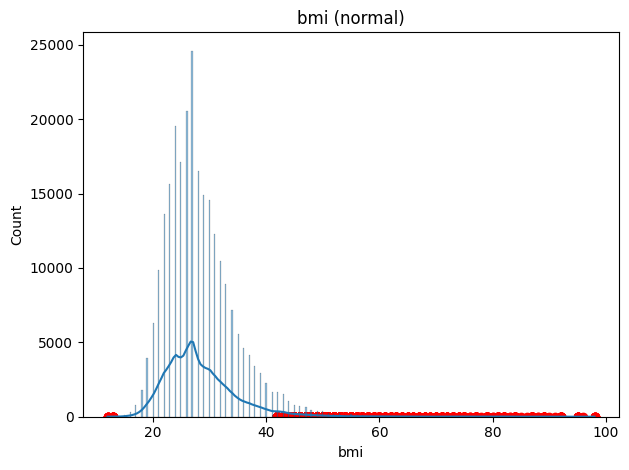

Upper Bound:  41.5 
Lower Bound:  13.5 
Num Outliers:  9847


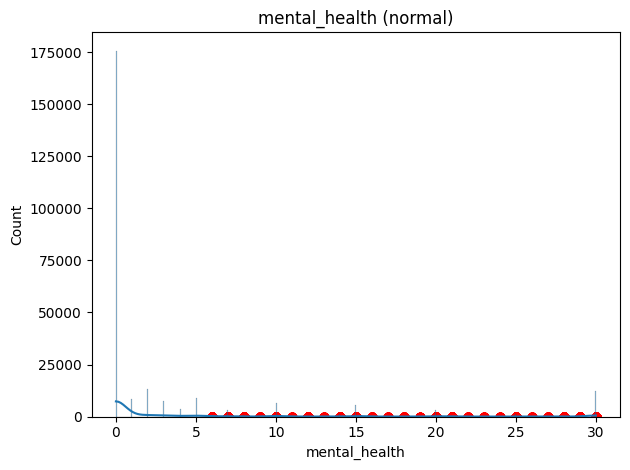

Upper Bound:  5.0 
Lower Bound:  -3.0 
Num Outliers:  36208


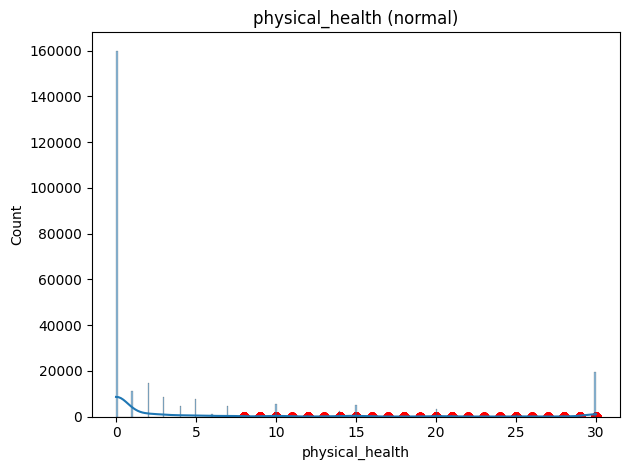

Upper Bound:  7.5 
Lower Bound:  -4.5 
Num Outliers:  40949


In [7]:
"""
    Outlier Detection:
"""

# Specify what features we want to detect outliers for
new_df = ds.data[ds.numeric_features].copy()

# Detect outliers
detect_outliers(new_df)

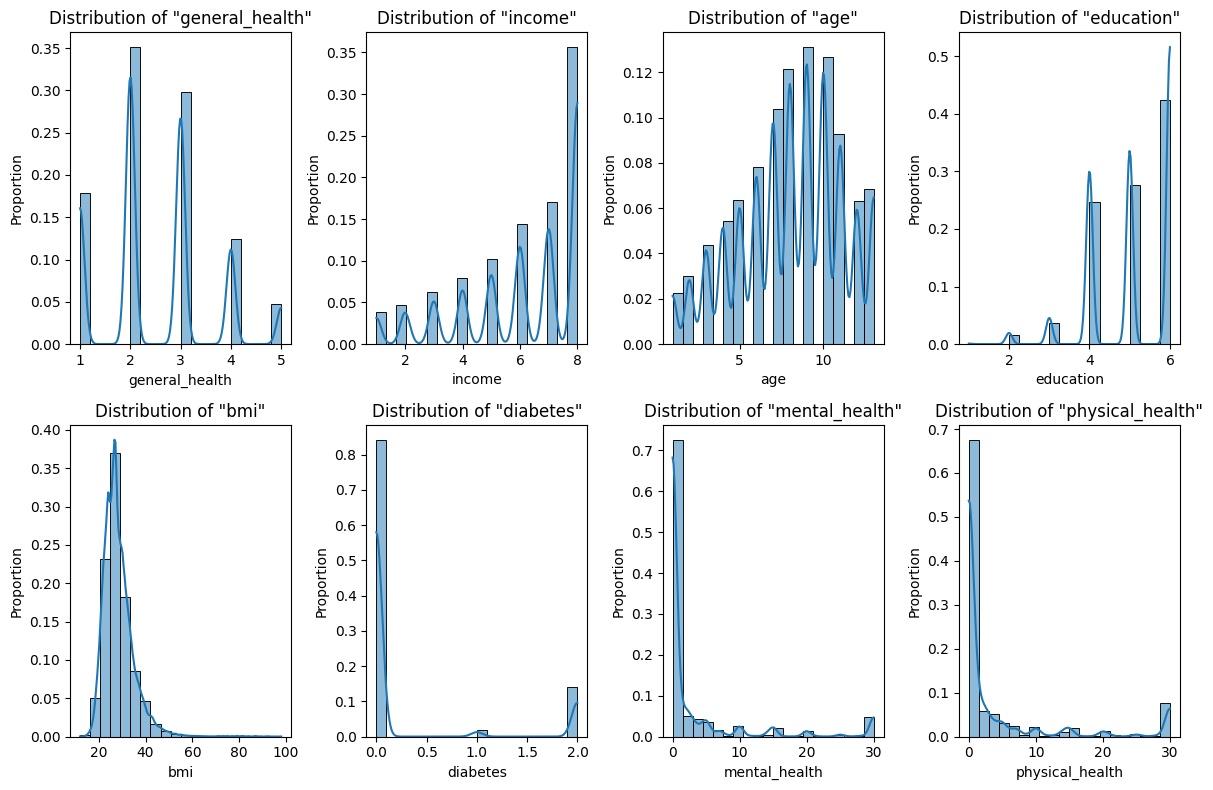

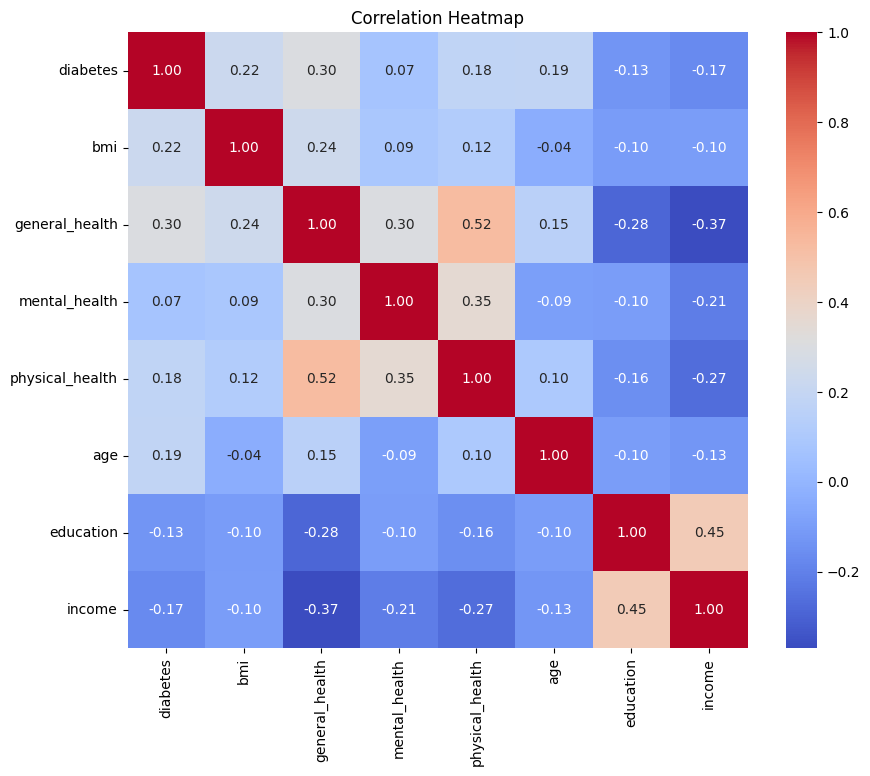

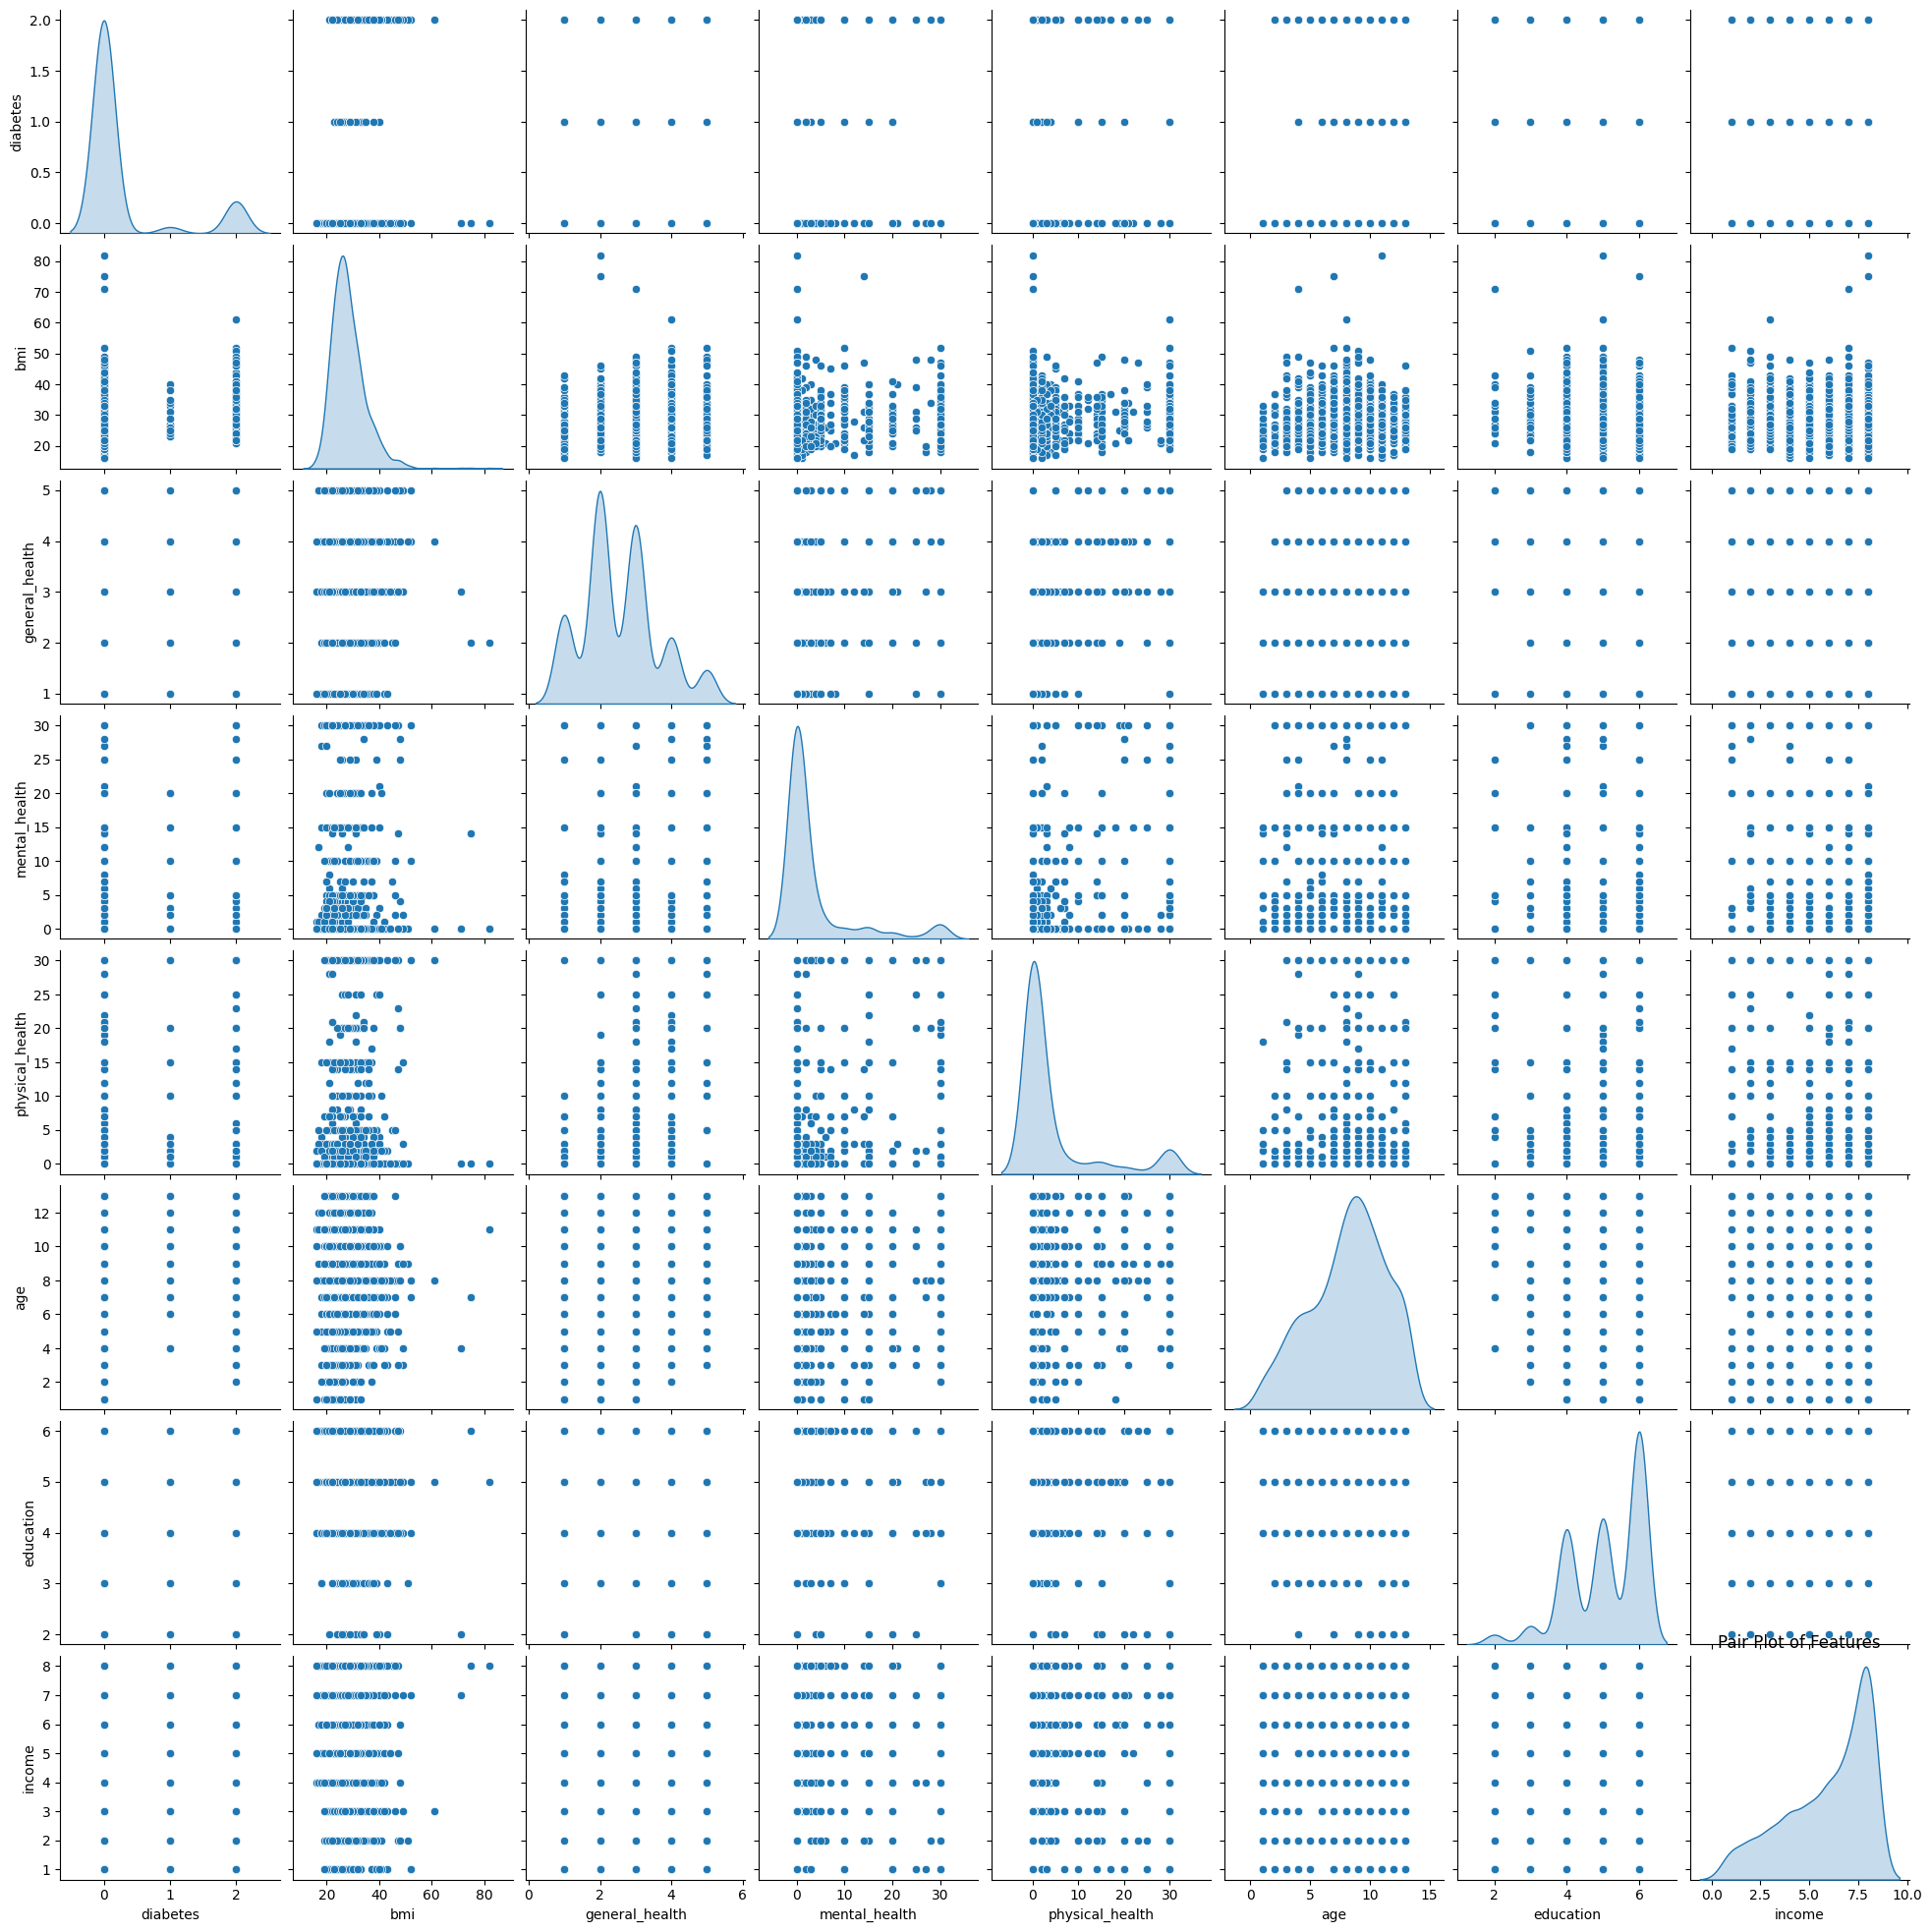

In [8]:
# visualizations
visualize_distributions(ds.data, cols=4, ignore_binary=True)
visualize_relationships(ds.data)

In [9]:
# target feature exploration
label_counts = target_explorations(ds.data, ds.target)
label_counts = {k: f"{v / ds.data.shape[0] * 100:.4f}%" for k, v in label_counts.items()}
print(label_counts)


<Target Distribution "diabetes">
Label `0` has 213703 observations ==> <WARNING> outside of balanced range of observations
Label `2` has 35346 observations ==> <WARNING> outside of balanced range of observations
Label `1` has 4631 observations ==> <WARNING> outside of balanced range of observations
{0: '84.2412%', 2: '13.9333%', 1: '1.8255%'}


## Transformation
Our work in the exploratory phase revealed a few key things:
1. There's not much data to clean, it's already very intact
2. There's a large imbalance in target labels, especially an overabundance of non-diabetes (84%) compared to with diabetes (2%).
3. The features are mostly categorically based (even normally numeric ones like `income` have been converted to a category (likely through some binning process))
4. There are a few features with slightly high correlations, but most features are non-collinear so we can use the majority of them if needed
5. In terms of outliers, there seems to be very few **<-- ENSURE THIS IS CORRECT**

As such, during the transformation phase we have a few goals in mind:
1. One-Hot encode the non-ordinal, but still categorical features
    1. If the feature is ordinal, we can assume a somewhat linear relationship already and avoid encoding in any form since there is a relationship between each level
    2. If there exists an ordinal feature that we can't assume a linear relationship for, we can also one-hot encode (but NN should capture non-linear trends so this may not be necessary)
    3. If the feature is non-ordinal, we can't assume any kind of inequality between labels, so we should enforce one-hot encoding on them
2. Narrow down our feature-set
    1. First, we'll remove the highly correlated features by either combining them or choosing the one with a better correlation with our target feature
    2. Then, we'll run logistic ridge regression as a base model to (i) get a baseline for our later ANN modeling and (ii) see which features are selected out via a near-zero coefficient after applying an L2 penalty
    3. Based on these two methods, we can reduce our feature count to only the most essential features
3. Up-Sample the positive (diabetes) and half-positive (pre-diabetes) labels so we don't create imbalanced training down the line
    1. We can either combine pre-diabetes and diabetes labels prior to upsampling or keep the multi-label context
    2. Since there are far too few diabetes observations and far too many non-diabetes observations, it's best to up-sample and not down-sample to avoid wasting the large amount of data we have for non-diabetes patients
    3. NOTE: we should be wary when modeling to extra penalize the positive label being incorrect and use F1-score over accuracy for measuring performance due to this imbalance
4. Standardize the numeric features (using Min-Max or Z-Score)

In [10]:
"""
    One-Hot Encoding & Standardization:
"""

# One-Hot Encoding
# features_to_encode = ["education"]
# ds.one_hot_encode(features_to_encode)

# Standardization
ds.normalize_features(how="zscore")
print(ds.data)

# re-check
numerical_summary(ds.data)

        diabetes  high_bp  high_chol  chol_check       bmi  smoker  stroke  \
0              0        1          1           1  1.757936       1       0   
1              0        0          0           0 -0.511806       1       0   
2              0        1          1           1 -0.057858       0       0   
3              0        1          0           1 -0.209174       0       0   
4              0        1          1           1 -0.663122       0       0   
...          ...      ...        ...         ...       ...     ...     ...   
253675         0        1          1           1  2.514516       0       0   
253676         2        1          1           1 -1.571019       0       0   
253677         0        0          0           1 -0.057858       0       0   
253678         0        1          0           1 -0.814438       0       0   
253679         2        1          1           1 -0.511806       0       0   

        heart_disease  physical_activity  fruits  ...  healthca

          feature-1          feature-2  correlation
0   physical_health     general_health     0.524364
1         diff_walk    physical_health     0.478417
2         diff_walk     general_health     0.456920
3            income          education     0.449106
4            income     general_health    -0.370014
5   physical_health      mental_health     0.353619
6               age            high_bp     0.344452
7            income          diff_walk    -0.320124
8     mental_health     general_health     0.301674
9    general_health            high_bp     0.300530
10        high_chol            high_bp     0.298199
11        education     general_health    -0.284912
12              age          high_chol     0.272318
13           income    physical_health    -0.266799
14   general_health  physical_activity    -0.266186
15   general_health      heart_disease     0.258383
16          veggies             fruits     0.254342
17        diff_walk  physical_activity    -0.253174


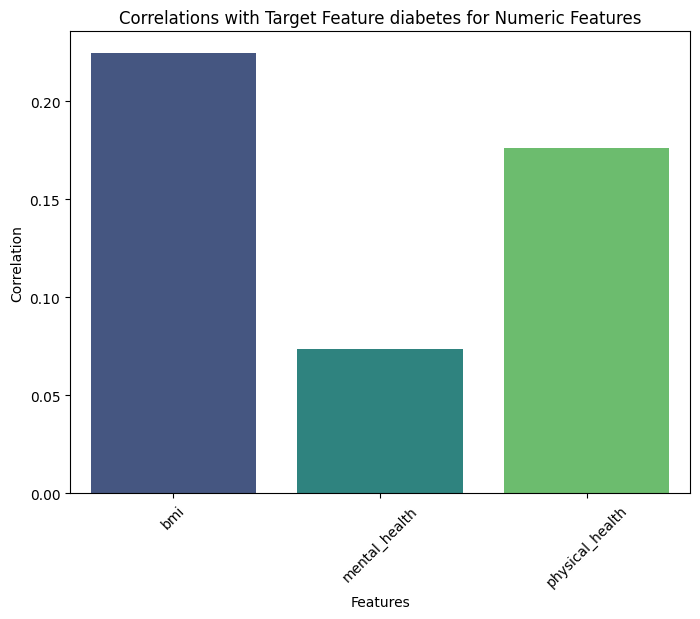

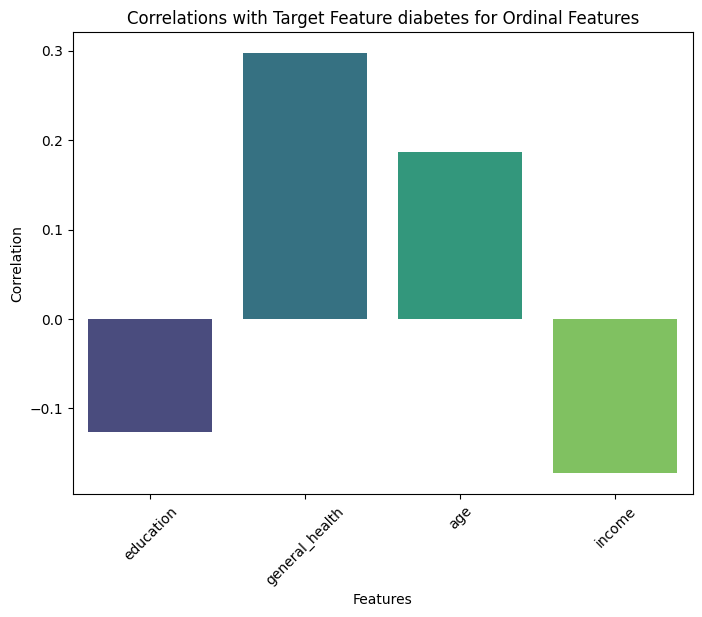

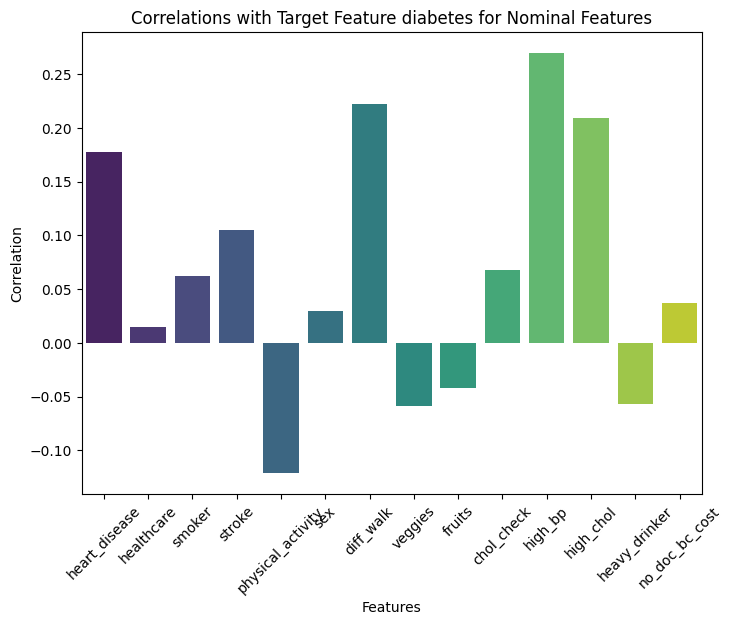

<Note> couldn't find obvious features to prune, listing lowest magnitude
{'age': 0.38686466286498095,
 'bmi': 0.409283368472636,
 'chol_check': 0.22525043268963443,
 'diff_walk': 0.040452819095511426,
 'education': -0.038238455013309046,
 'fruits': -0.022366710145031346,
 'general_health': 0.5488959199365635,
 'healthcare': 0.01189781906734162,
 'heart_disease': 0.05794784606457295,
 'heavy_drinker': -0.1548901325638145,
 'high_bp': 0.35245614527152747,
 'high_chol': 0.29370681374940677,
 'income': -0.11580359956575298,
 'mental_health': -0.015056735729527603,
 'no_doc_bc_cost': 0.020817236993936773,
 'physical_activity': -0.020169341446846113,
 'physical_health': -0.06148629841303449,
 'sex': 0.11894942600259575,
 'smoker': -0.006792255888325677,
 'stroke': 0.021283402204831388,
 'veggies': -0.014366435837253362}
{'healthcare': 0.01189781906734162,
 'mental_health': 0.015056735729527603,
 'physical_activity': 0.020169341446846113,
 'smoker': 0.006792255888325677,
 'veggies': 0.0143664

In [11]:
"""
    Feature Selection: we only want to select features with low collinearity 
    with other features and a strong relationship with the target variable. To 
    do this, we can re-consult the correlation matrix (except now include 
    categorical features) and check the correlations with the target feature.
"""

# collinearity
collinearity_df = collinearity_check(ds.data, ds.target)

# target correlations
corr_dict = visualize_target_corr(
    ds.data,
    ds.target,
    numeric_features=ds.numeric_features,
    ordinal_features=ds.ordinal_features,
    nominal_features=ds.nominal_features,
    feature_set=ds.feature_set
)

# get pruned features
pruned_features, keep_features, coefs = feature_selection(
    ds.data,
    ds.target,
    numeric_features=ds.numeric_features
)

##### Context-Driven Selection & Finalized Feature Selection
ooga booga

In [12]:
"""
    Up-Sampling: 

    Cannot be inplace because you can't replace an existing df with a concatenation.
"""
ds.data = up_sampling(ds.data, "diabetes")

# Confirming upsampling
label_counts = target_explorations(ds.data, ds.target)
label_counts = {k: f"{v / ds.data.shape[0] * 100:.4f}%" for k, v in label_counts.items()}
print(label_counts)


<Target Distribution "diabetes">
Label `0` has 213703 observations ==> within tolerance range...
Label `1` has 213703 observations ==> within tolerance range...
Label `2` has 213703 observations ==> within tolerance range...
{0: '33.3333%', 1: '33.3333%', 2: '33.3333%'}
